In [1]:
import os
import sys
sys.path.insert(0, os.path.relpath('../../../../../..'))

from importlib import reload
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from recidiviz.calculator.modeling.population_projection.simulations.super_simulation_factory import SuperSimulationFactory
from recidiviz.calculator.modeling.population_projection.shell_compartment import ShellCompartment
from recidiviz.calculator.modeling.population_projection.spark_policy import SparkPolicy
from recidiviz.calculator.modeling.population_projection.compartment_transitions import CompartmentTransitions


In [2]:
test_sim = SuperSimulationFactory.build_super_simulation('../../state/IL/IL_prison_RAE_model_inputs.yaml')
# test_sim.simulate_baseline('pretrial', 'prison')

/Users/justine/.local/share/virtualenvs/pulse-data-xK3VhzVV/lib/python3.7/site-packages/google/cloud/bigquery/table.py:1728: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  create_bqstorage_client=create_bqstorage_client,


outflows_data returned 252 results
transitions_data returned 237 results
total_population_data returned 252 results


initialization time:  54.312472105026245
simulation_time:  40.890960931777954
initialization time:  48.504374980926514
simulation_time:  40.720621824264526


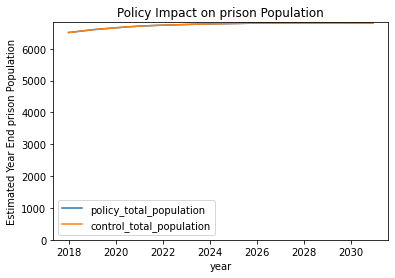

In [3]:
tis_percentages = {
    '100%': 1, 
    '85%': 0.85, 
    '50%': 0.5, 
}


# Policy Option Methods
def remove_automatic_enhancement(tis_percentage, retroactive=False):
    return partial(CompartmentTransitions.apply_reduction, 
                   reduction_dict={'probation': {'reduction_size': 15 * 12 * tis_percentages[tis_percentage],
                                                 'affected_fraction': 1}
                                  }, 
                   reduction_type='+',
                   retroactive=retroactive
                  )


policy_list_non_retroactive = [
    SparkPolicy(policy_fn=remove_automatic_enhancement(tis_percentage),
                spark_compartment='prison',
                sub_population={'tis_percentage': tis_percentage},
                apply_retroactive=False)
    for tis_percentage in tis_percentages
]
    
test_results = test_sim.simulate_policy(policy_list_non_retroactive, 'prison')

In [3]:
data = test_sim.pop_simulations['baseline'].sub_simulations['50%'].total_population_data
data.index = data.time_step
data.total_population.plot()

KeyError: 'baseline'

In [14]:
simulation_tag = 'IL_remove_automatic_enhancements'
test_sim.upload_simulation_results_to_bq('recidiviz-staging', simulation_tag)